In [ ]:
pip install tensorflow nltk --quiet

In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer  # Updated import
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Updated import
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


#Attention Layer

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class ScaledDotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)

    def call(self, inputs):
        encoder_out_seq, decoder_out_seq = inputs

        #Calculate the dot products
        scores = tf.matmul(decoder_out_seq, encoder_out_seq, transpose_b=True)

        #Scale the scores
        d_k = tf.cast(tf.shape(encoder_out_seq)[-1], tf.float32)
        scaled_scores = scores / tf.sqrt(d_k)
        #Calculate attention weights
        attention_weights = tf.nn.softmax(scaled_scores, axis=-1)

        #Compute the context vector
        context_vector = tf.matmul(attention_weights, encoder_out_seq)

        return context_vector, attention_weights

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


#Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/data/Reviews.csv',nrows=100000)

In [ ]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
#Drop Duplicates and null values
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk


#Remove stop workds and very small words as well

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if len(i) >= 3:
            long_words.append(i)
    return (" ".join(long_words)).strip()


cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Summary Cleaning

In [ ]:
data['Summary'][:10]

In [ ]:
#Clean summary data

def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

#Call the summary_cleaner
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

#Analyze data

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

#populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
max_len_text=150

#icnrease
max_len_summary=20

In [ ]:
from sklearn.model_selection import train_test_split

#Split training and testing data

x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [ ]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr)
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
#preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr)
y_val   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

#Model


In [ ]:
'''
from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_emb =  Embedding(x_voc_size, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc_size, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = ScaledDotProductAttention(name='scaled_dot_product_attention')
attn_out, attn_weights = attn_layer([encoder_outputs, decoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()
'''
from keras import backend as K
from keras.layers import Input, Embedding, LSTM, Bidirectional, Concatenate, TimeDistributed, Dense
from keras.models import Model

K.clear_session()

latent_dim = 300
embedding_dim = 100

#Encoder
encoder_inputs = Input(shape=(max_len_text,))

#Embedding layer
enc_emb = Embedding(x_voc_size, embedding_dim, trainable=True)(encoder_inputs)

#Bidirectional encoder LSTM 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)
state_h1 = Concatenate()([forward_h1, backward_h1])
state_c1 = Concatenate()([forward_c1, backward_c1])

#Bidirectional encoder LSTM 2
encoder_lstm2 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_output1)
state_h2 = Concatenate()([forward_h2, backward_h2])
state_c2 = Concatenate()([forward_c2, backward_c2])

#Bidirectional encoder LSTM 3
encoder_lstm3 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
encoder_outputs, forward_h3, forward_c3, backward_h3, backward_c3 = encoder_lstm3(encoder_output2)
state_h = Concatenate()([forward_h3, backward_h3])
state_c = Concatenate()([forward_c3, backward_c3])

#Decoder setup, using encoder final states as initial state
decoder_inputs = Input(shape=(None,))

#Embedding layer for the decoder
dec_emb_layer = Embedding(y_voc_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#Decoder LSTM (unidirectional)
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#Attention layer (assuming you have a custom attention layer)
attn_layer = ScaledDotProductAttention(name='scaled_dot_product_attention')
attn_out, attn_weights = attn_layer([encoder_outputs, decoder_outputs])

#Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 100)       │      5,177,300 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ [(None, 100, 600),     │        962,400 │ embedding[0][0]        │
│ (Bidirectional)           │ (None, 300), (None,    │                │                        │
│                           │ 300), (None, 300),     │                │                        │
│                           │ (None, 300)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ [(None, 100, 600),     │      2,162,400 │ bidirectional[0][0]    │
│ (Bidirectional)           │ (None, 300), (None,    │                │                        │
│                           │ 300), (None, 300),     │                │                        │
│                           │ (None, 300)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ [(None, 100, 600),     │      2,162,400 │ bidirectional_1[0][0]  │
│ (Bidirectional)           │ (None, 300), (None,    │                │                        │
│                           │ 300), (None, 300),     │                │                        │
│                           │ (None, 300)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │      1,414,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 600)            │              0 │ bidirectional_2[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_2[0][3]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 600)            │              0 │ bidirectional_2[0][2], │
│ (Concatenate)             │                        │                │ bidirectional_2[0][4]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 600),    │      1,682,400 │ embedding_1[0][0],     │
│                           │ (None, 600), (None,    │                │ concatenate_4[0][0],   │
│                           │ 600)]                  │                │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ scaled_dot_product_atten… │ [(None, None, 600),    │              0 │ bidirectional_2[0][0], │
│ (ScaledDotProductAttenti… │ (None, None, 100)]     │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 1200)     │              0 │ lstm_3[0][0],          │
│ (Concatenate)        

 Total params: 30,548,244 (116.53 MB)

 Trainable params: 30,548,244 (116.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler


#model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

#Use adamW optimizer
model.compile(optimizer='adamW', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#EarlyStopping callback to prevent overfitting
es= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
#Check shape of data
print("x_tr shape:", x_tr.shape)
print("y_tr shape:", y_tr.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_tr shape: (79515, 100)
y_tr shape: (79515, 8)
x_val shape: (8835, 100)
y_val shape: (8835, 8)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler


#Learning rate scheduler to adjust learning rate at certain intervals
def lr_scheduler(epoch, lr):
    if epoch > 7:
        return lr * 0.1
    return lr




In [ ]:
history = model.fit(
    #encoder input and decoder
    input
    [x_tr, y_tr[:, :-1]],

    #Integer targets
    y_tr[:, 1:],

    epochs=50,
    callbacks=[es],
    batch_size=512,
    validation_data=(

        #Validation Data
        [x_val, y_val[:, :-1]],

        #integer validation targets
        y_val[:, 1:]
    )
)

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.4102 - loss: 4.7402 - val_accuracy: 0.5144 - val_loss: 3.3997
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.5050 - loss: 3.4977 - val_accuracy: 0.5223 - val_loss: 3.2783
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.5137 - loss: 3.3487 - val_accuracy: 0.5322 - val_loss: 3.1572
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.5239 - loss: 3.1932 - val_accuracy: 0.5416 - val_loss: 3.0322
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.5318 - loss: 3.0519 - val_accuracy: 0.5471 - val_loss: 2.9536
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.5392 - loss: 2.9373 - val_accuracy: 0.5521 - val_loss: 2.9021
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.5453 - loss: 2.8429 - val_accuracy: 0.5569 - val_loss: 2.8608
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.5507 - loss: 2.7548 - val_accu

In [ ]:
#Save the model to Google Drive
model.save('/content/drive/MyDrive/SD/model_63_2nd.keras')

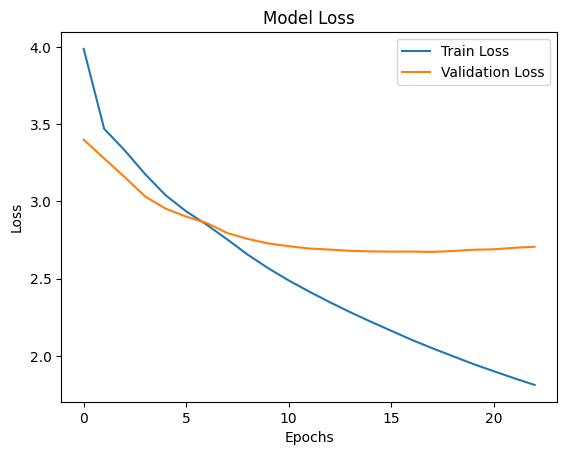

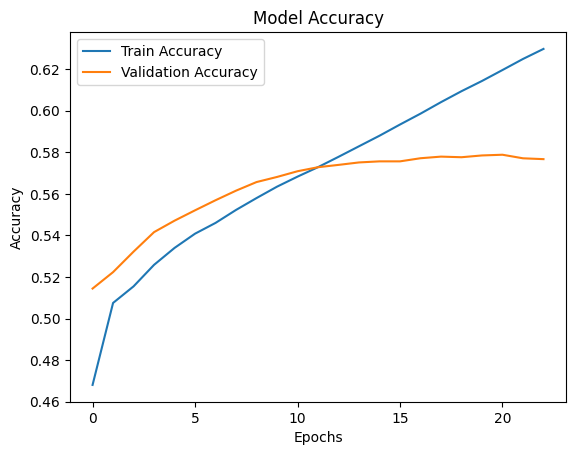

In [ ]:
from matplotlib import pyplot as plt

#Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


#Inferencing

In [ ]:

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
'''
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])
'''

#Encoder inference model
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

#Decoder inference model adjustments
decoder_state_input_h = Input(shape=(latent_dim * 2,))
decoder_state_input_c = Input(shape=(latent_dim * 2,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim * 2))

#Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

#Set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

#Attention inference layer
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

#Concatenate attention output and decoder LSTM output
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#Dense softmax layer to generate probability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

#Final decoder model for inference
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)


In [ ]:
#Functino for decode sequence

def decode_sequence(input_seq):
    #Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    #Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    #Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        #Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #Handle unknown tokens
        sampled_token = reverse_target_word_index.get(sampled_token_index, '<UNK>')

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            #Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        #Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        #Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
#Used to create clean summaries from inference
#remove null token
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):

        word = reverse_target_word_index.get(i, '')
        if word:
          newString = newString + word + ' '
    return newString.strip()

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
print("Keys in reverse_target_word_index:", reverse_target_word_index.keys())


Keys in reverse_target_word_index: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 21

In [ ]:
for i in range(len(x_val)):

  #
  print("Article:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))

  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted summary:  delicious <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


Article: favorite cereal quick easy make single serving half recipe box also put microwave make sure put power otherwise microwave great tasting healthy keeps full longer time cereals part heart healthy diet got dad eating heart attack loves canada tastes like red river states pay shipping charges tastes great little brown sugar agave milk 
Original summary: favorite cereal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━

In [ ]:
!pip install rouge --quiet

In [ ]:
from rouge import Rouge

rouge = Rouge()

def calculate_rouge(reference_summaries, predicted_summaries):
    """
    Calculates ROUGE scores for a list of reference summaries and predicted summaries.

    Args:
        reference_summaries: A list of reference summaries (strings).
        predicted_summaries: A list of predicted summaries (strings).

    Returns:
        A dictionary containing ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    if not reference_summaries or not predicted_summaries:
        print("Error: Empty reference or predicted summaries list.")
        return None

    #Filter out empty summaries
    valid_pairs = [(ref, pred) for ref, pred in zip(reference_summaries, predicted_summaries) if ref and pred]

    if not valid_pairs:
        print("Error: No valid summary pairs found.")
        return None

    valid_references, valid_predictions = zip(*valid_pairs)

    try:
        scores = rouge.get_scores(valid_predictions, valid_references, avg=True)
        return scores
    except ValueError as e:
        print(f"Error calculating ROUGE scores: {e}")
        return None

In [ ]:
reference_summaries = []
predicted_summaries = []

for i in range(min(100, len(x_val))):
    original_summary = seq2summary(y_val[i])
    predicted_summary = decode_sequence(x_val[i].reshape(1, max_len_text))

    if original_summary and predicted_summary:
        reference_summaries.append(original_summary)
        predicted_summaries.append(predicted_summary)

print(f"Number of reference summaries: {len(reference_summaries)}")
print(f"Number of predicted summaries: {len(predicted_summaries)}")

if reference_summaries and predicted_summaries:
    print("First reference summary:", reference_summaries[0])
    print("First predicted summary:", predicted_summaries[0])

rouge_scores = calculate_rouge(reference_summaries, predicted_summaries)
if rouge_scores:
    print("ROUGE Scores:", rouge_scores)
else:
    print("Failed to calculate ROUGE scores.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━